In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

import sys
import statsmodels as ss
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset

confirmed =  pd.read_csv('/content/drive/MyDrive/313/confirmed.csv')


In [ ]:
del confirmed['Province/State']
del confirmed['Lat']
del confirmed['Long']

In [ ]:
confirmed


,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,62718,63045,63355,63412,63484,63598,63819,64122,64575,65080
1,Albania,0,0,0,0,0,0,0,0,0,...,131845,131890,131939,131978,132015,132032,132071,132095,132118,132153
2,Algeria,0,0,0,0,0,0,0,0,0,...,124682,124889,125059,125194,125311,125485,125693,125896,126156,126434
3,Andorra,0,0,0,0,0,0,0,0,0,...,13470,13470,13510,13510,13510,13555,13569,13569,13569,13569
4,Angola,0,0,0,0,0,0,0,0,0,...,29405,29695,30030,30354,30637,30787,31045,31438,31661,31909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,Vietnam,0,2,2,2,2,2,2,2,2,...,3658,3740,3816,4112,4212,4359,4512,4720,4809,4941
271,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,303270,303270,303270,303658,303827,304074,304074,304532,304532,304968
272,Yemen,0,0,0,0,0,0,0,0,0,...,6498,6507,6523,6538,6543,6568,6586,6593,6613,6632
273,Zambia,0,0,0,0,0,0,0,0,0,...,92211,92262,92356,92409,92436,92460,92520,92630,92754,92920


In [ ]:
country = 'Philippines'

In [ ]:
confirmed_phil = confirmed.loc[confirmed['Country/Region'] == 'Philippines']
confirmed_phil = pd.DataFrame(confirmed_phil[confirmed_phil.columns[1:]].sum(),columns=['confirmed'])
confirmed_phil.index = pd.to_datetime(confirmed_phil.index,format='%m/%d/%y')


In [ ]:
confirmed_phil

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2021-05-17,1149925
2021-05-18,1154388
2021-05-19,1159071
2021-05-20,1165155


<Axes: >

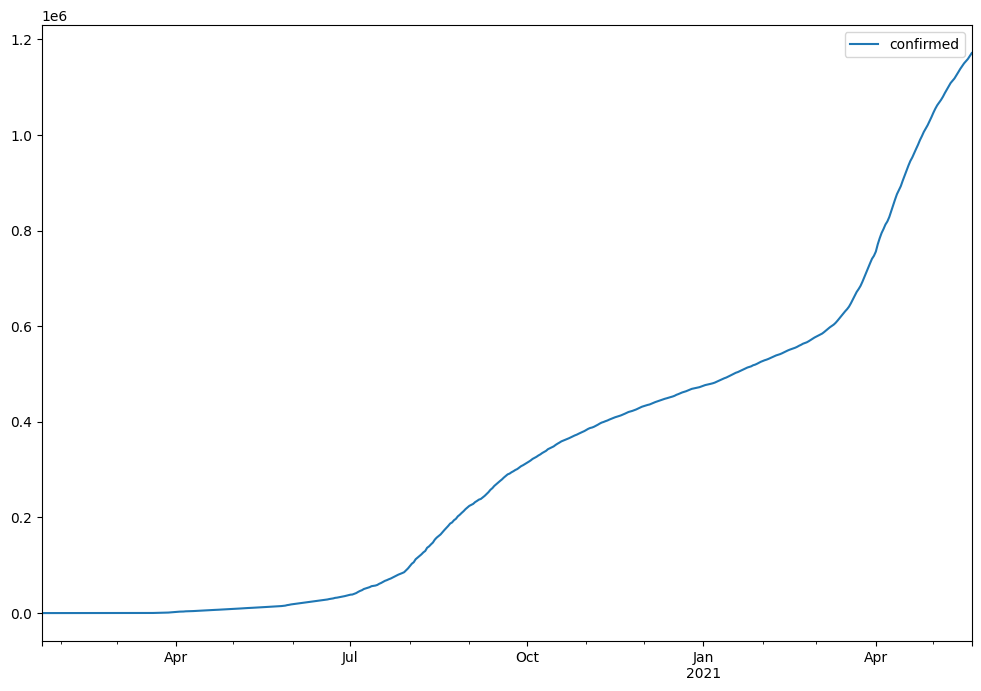

In [ ]:
confirmed_phil.plot(figsize=(12,8))

# **ARIMA**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
acf(confirmed_phil['confirmed'])

array([1.        , 0.99147327, 0.9829277 , 0.97436239, 0.96575466,
       0.95710057, 0.94842664, 0.93972858, 0.93102302, 0.92231198,
       0.91359138, 0.90483594, 0.89604479, 0.88725512, 0.87847189,
       0.86969268, 0.86093271, 0.8521754 , 0.84340621, 0.83462626,
       0.82586364, 0.81713752, 0.80846427, 0.79983775, 0.79125252,
       0.78268697, 0.77414769])

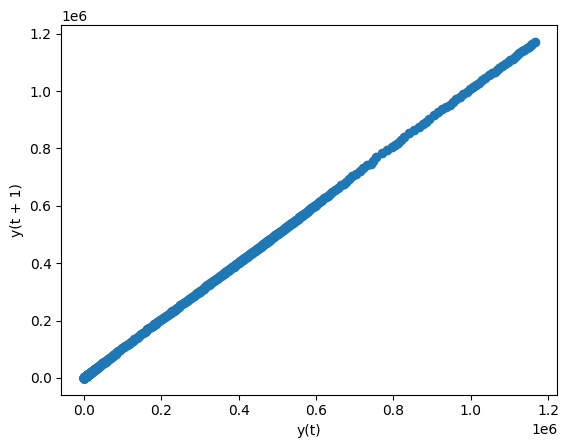

In [ ]:
from pandas.plotting import lag_plot

lag_plot(confirmed_phil);

In [ ]:
from statsmodels.tsa.statespace.tools import diff
confirmed_phil['d1'] = diff(confirmed_phil['confirmed'],k_diff=2)


adf_test(confirmed_phil['d1'],'Deaths')

Augmented Dickey-Fuller Test: Deaths
ADF test statistic       -3.594513
p-value                   0.005867
# lags used              15.000000
# observations          468.000000
critical value (1%)      -3.444400
critical value (5%)      -2.867736
critical value (10%)     -2.570070
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


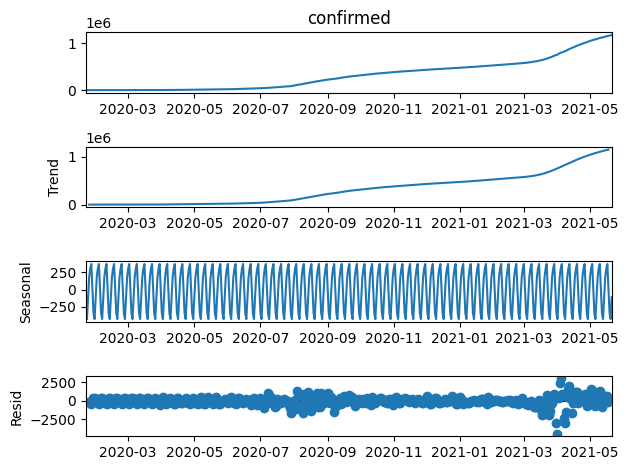

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(confirmed_phil['confirmed'], model='additive')
result.plot();

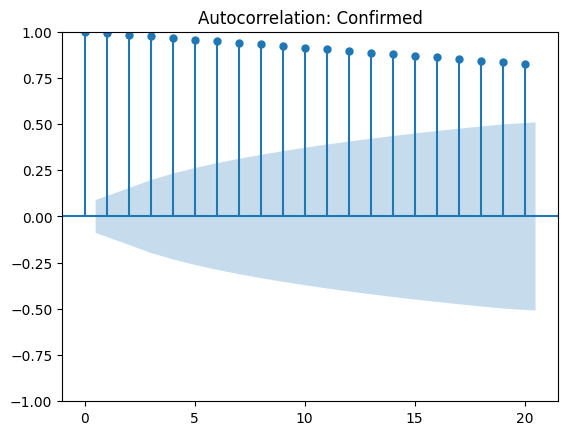

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
title = 'Autocorrelation: Confirmed'
lags = 20
plot_acf(confirmed_phil,title=title,lags=lags);

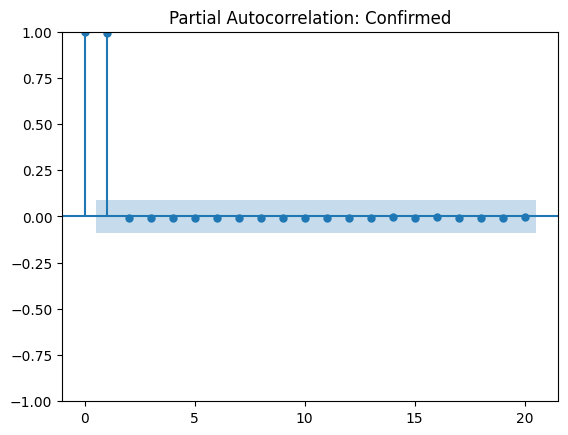

In [ ]:
title='Partial Autocorrelation: Confirmed'
lags=20
plot_pacf(confirmed_phil,title=title,lags=lags);

In [ ]:

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders


In [ ]:
len(confirmed_phil)

486

In [ ]:

train = confirmed_phil.iloc[:457]
test = confirmed_phil.iloc[457:]

In [ ]:
model_ARIMA = ARIMA(confirmed_phil['confirmed'],order=(2,2,3)) #order from acf and pacf plot
results = model_ARIMA.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              confirmed   No. Observations:                  486
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -3855.195
Date:                Thu, 27 Apr 2023   AIC                           7722.390
Time:                        15:01:47   BIC                           7747.483
Sample:                    01-22-2020   HQIC                          7732.250
                         - 05-21-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2416      0.016     78.594      0.000       1.211       1.273
ar.L2         -0.9904      0.015    -68.001      0.000      -1.019      -0.962
ma.L1         -1.7832      0.044    -40.340      0.000      -1.870      -1.697
ma.L2          1.5998      0.065     24.440      0.000       1.471       1.728
ma.L3         -0.5271      0.041    -12.760      0.000      -0.608      -0.446
sigma2      6.151e+05   2.08e+04     29.602      0.000    5.74e+05    6.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.94   Jarque-Bera (JB):              4806.41
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):              40.90   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA(2, 2, 3) Predictions')


In [ ]:
predictions

2021-04-23    9.815770e+05
2021-04-24    9.898792e+05
2021-04-25    9.987345e+05
2021-04-26    1.005198e+06
2021-04-27    1.013892e+06
2021-04-28    1.021021e+06
2021-04-29    1.028531e+06
2021-04-30    1.037922e+06
2021-05-01    1.046856e+06
2021-05-02    1.055470e+06
2021-05-03    1.062562e+06
2021-05-04    1.068900e+06
2021-05-05    1.074196e+06
2021-05-06    1.080481e+06
2021-05-07    1.088034e+06
2021-05-08    1.096123e+06
2021-05-09    1.101994e+06
2021-05-10    1.108140e+06
2021-05-11    1.114550e+06
2021-05-12    1.118832e+06
2021-05-13    1.124256e+06
2021-05-14    1.131864e+06
2021-05-15    1.138848e+06
2021-05-16    1.144800e+06
2021-05-17    1.149235e+06
2021-05-18    1.154831e+06
2021-05-19    1.159141e+06
2021-05-20    1.164564e+06
2021-05-21    1.171828e+06
Freq: D, Name: ARIMA(2, 2, 3) Predictions, dtype: float64

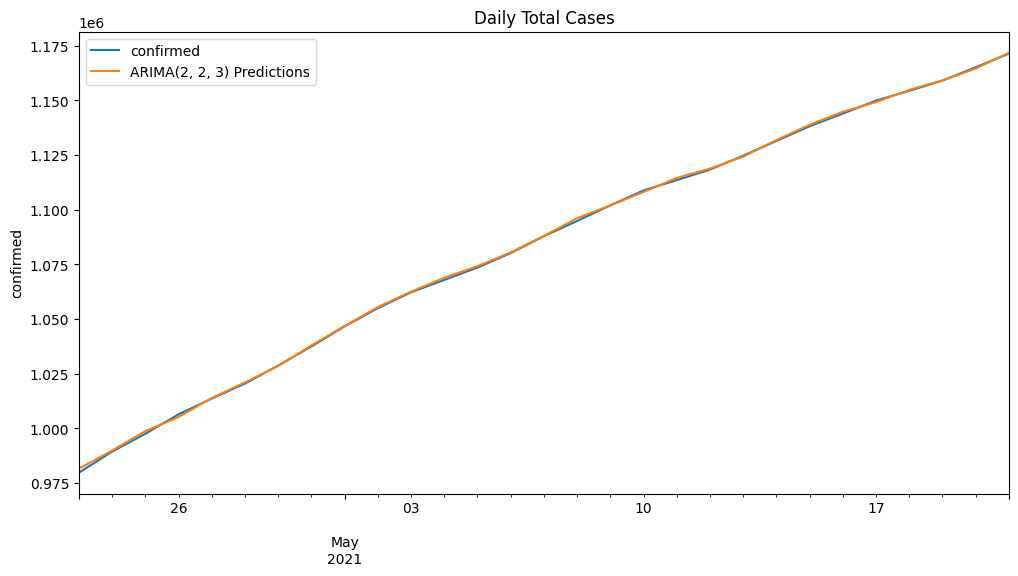

In [ ]:

title = 'Daily Total Cases'
ylabel='confirmed'
xlabel='' # we don't really need a label here

# Plot predictions against known values

ax = test['confirmed'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

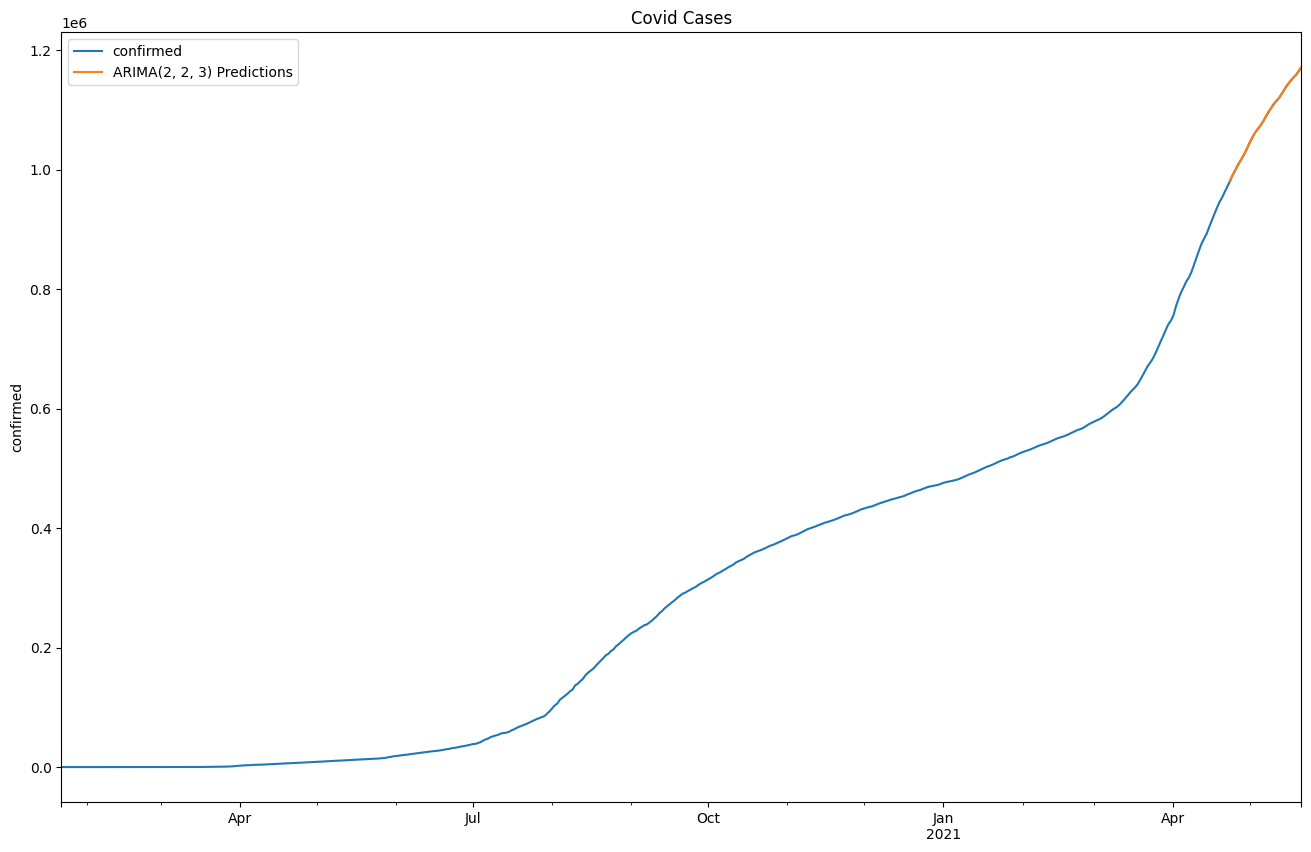

In [ ]:
title = 'Covid Cases'
ylabel='confirmed'
xlabel=''

ax = confirmed_phil['confirmed'].plot(legend=True,figsize=(16,10),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

error = mean_squared_error(test['confirmed'], predictions)
print(f'ARIMA(2, 2, 3) MSE Error: {error:11.10}')

ARIMA(2, 2, 3) MSE Error: 524039.6234


In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['confirmed'], predictions)
print(f'ARIMA(2, 2, 3) RMSE Error: {error:11.10}')

ARIMA(2, 2, 3) RMSE Error: 723.9058111


In [ ]:
error = mean_absolute_error(test['confirmed'], predictions)
print(f'ARIMA(2, 2, 3) MAE Error: {error:11.10}')

ARIMA(2, 2, 3) MAE Error: 600.1838816
